# mesh compression

In [1]:
import os
import time
import re
import struct

import numpy as np
import DracoPy
from pyntcloud import PyntCloud
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


sample code for compressing via Google DracoPy

# transform .obj to lists to match Draco requirements

read obj as text string without using any package  
note: read obj directly to mesh object using open3d is below

In [2]:
def from_obj(text):

    vertices = []
    faces = []
    normals = []

    if type(text) is bytes:
      text = text.decode('utf8')

    for line in text.split('\n'):
      line = line.strip()
      if len(line) == 0:
        continue
      elif line[0] == '#':
        continue
      elif line[0] == 'f':
        if line.find('/') != -1:
          # e.g. f 6092/2095/6079 6087/2092/6075 6088/2097/6081
          (v1, vt1, vn1, v2, vt2, vn2, v3, vt3, vn3) = re.match(r'f\s+(\d+)/(\d*)/(\d+)\s+(\d+)/(\d*)/(\d+)\s+(\d+)/(\d*)/(\d+)', line).groups()
        else:
          (v1, v2, v3) = re.match(r'f\s+(\d+)\s+(\d+)\s+(\d+)', line).groups()
        faces.append( (int(v1), int(v2), int(v3)) )
      elif line[0] == 'v':
        if line[1] == 't': # vertex textures not supported
          # e.g. vt 0.351192 0.337058
          continue 
        elif line[1] == 'n': # vertex normals
          # e.g. vn 0.992266 -0.033290 -0.119585
          (n1, n2, n3) = re.match(r'vn\s+([-\d\.]+)\s+([-\d\.]+)\s+([-\d\.]+)', line).groups()
          normals.append( (float(n1), float(n2), float(n3)) )
        else:
          # e.g. v -0.317868 -0.000526 -0.251834
          (v1, v2, v3) = re.match(r'v\s+([-\d\.]+)\s+([-\d\.]+)\s+([-\d\.]+)', line).groups()
          vertices.append( (float(v1), float(v2), float(v3)) )

    vertices = np.array(vertices, dtype=np.float32)
    faces = np.array(faces, dtype=np.uint32)
    normals = np.array(normals, dtype=np.float32)

    return vertices, faces - 1, normals

In [3]:
with open('bunny/bunny_text.txt', 'r') as f:
    text = f.read()
vertices, faces, _ = from_obj(text)

encode bunny

In [4]:
list1 = []

In [17]:
start = time.time()

encoded_mesh = DracoPy.encode_mesh_to_buffer(list(vertices.reshape(-1)), list(faces.reshape(-1)))
with open('bunny/bunny_draco.drc', 'wb') as mesh_file:
    mesh_file.write(encoded_mesh)
    
list1.append(time.time()-start)
print('encode time', time.time()-start, 's')

encode time 0.11687350273132324 s


In [18]:
time1 = np.average(list1)

decode bunny

In [19]:
list2 = []

In [32]:
start = time.time()

with open('bunny/bunny_draco.drc', 'rb') as draco_file:
    file_content = draco_file.read()
    mesh_object = DracoPy.decode_buffer_to_mesh(file_content)

list2.append(time.time()-start)
print('decode time', time.time()-start, 's')

decode time 0.02793574333190918 s


In [33]:
time2 = np.average(list2)

In [34]:
print('number of points in original file: {0}'.format(vertices.shape[0]))
print('number of faces in original file: {0}'.format(faces.shape[0]))

with open('bunny/bunny_draco.drc', 'rb') as draco_file:
    file_content = draco_file.read()
    mesh_object = DracoPy.decode_buffer_to_mesh(file_content)
    print('number of points in decoded file: {0}'.format(int( len(mesh_object.points)/3 )))
    print('number of faces in decoded file: {0}'.format(int( len(mesh_object.faces)/3 )))

number of points in original file: 34834
number of faces in original file: 69451
number of points in decoded file: 34834
number of faces in decoded file: 69451


In [35]:
print('average encode time: {0}s'.format(time1))
print('average decode time: {0}s'.format(time2))

average encode time: 0.1125778601719783s
average decode time: 0.02893225963299091s


# 3D representation transformation

# -- mesh to point cloud

In [36]:
def mesh_to_pc(ori_path, target_path, n_samples=500000, vg_size=64):
    pc_mesh = PyntCloud.from_file(ori_path)
    mesh = pc_mesh.mesh
    pc_mesh.points = pc_mesh.points.astype('float64', copy=False)
    pc_mesh.mesh = mesh

    pc = pc_mesh.get_sample("mesh_random", n=n_samples, as_PyntCloud=True)
    coords = ['x', 'y', 'z']
    points = pc.points.values
    #points = points - np.min(points)
    #points = points / np.max(points)
    #points = points * (vg_size - 1)
    #points = np.round(points)
    pc.points[coords] = points
    if len(set(pc.points.columns) - set(coords)) > 0:
        pc.points = pc.points.groupby(by=coords, sort=False).mean()
    else:
        pc.points = pc.points.drop_duplicates()

    pc.to_file(target_path)

In [37]:
ori_path = 'bunny/bunny.obj'
target_path = 'bunny/bunny_pc.ply'

mesh_to_pc(ori_path, target_path)

# bunny_pc.ply for PCGC
# bunny_pc_prepared.ply for VoxelDNN, the points are arranged into n^3 voxel grid

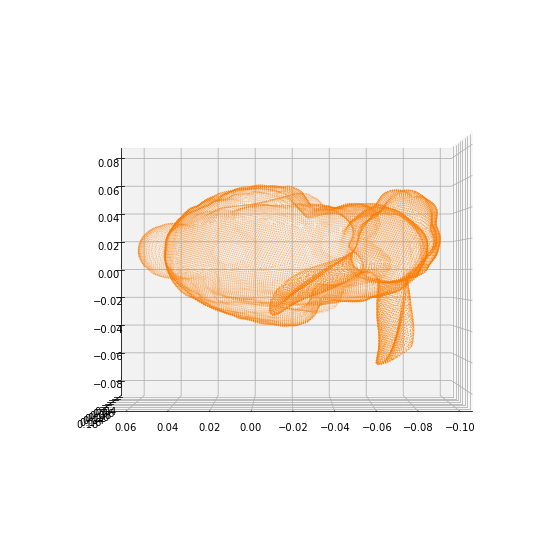

In [38]:
PyntCloud.from_file(ori_path).plot()

# mesh = o3d.io.read_triangle_mesh("bunny.obj")
# o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

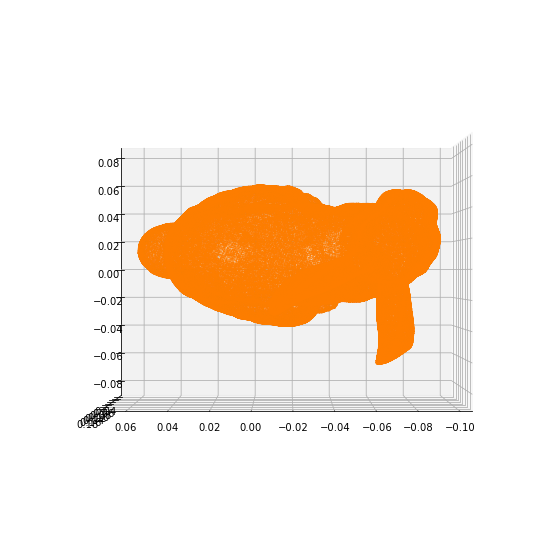

In [39]:
PyntCloud.from_file(target_path).plot()

# -- point cloud to mesh
reference: https://towardsdatascience.com/5-step-guide-to-generate-3d-meshes-from-point-clouds-with-python-36bad397d8ba

In [40]:
pcd = o3d.io.read_point_cloud("dancer/dancer_vox11_00000001.ply")
print(len(np.asarray(pcd.points)))

# reconstruction needs normals
pcd.estimate_normals()

2592758


In [41]:
o3d.visualization.draw_geometries([pcd])#, point_show_normal=True)

method: poisson reconstruction

In [42]:
#computing the mesh
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, width=0, scale=1.1, linear_fit=False)[0]

#cropping
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [43]:
o3d.visualization.draw_geometries([p_mesh_crop])

save

In [44]:
o3d.io.write_triangle_mesh("dancer/dancer_mesh.obj", p_mesh_crop)

True

# -- compression

In [50]:
file_path =  'dancer/dancer_mesh.obj' # 'bunny/bunny.obj'
compressed_path = 'bunny/bunny_draco.drc'  # 'dancer/dancer_draco.drc'

mesh = o3d.io.read_triangle_mesh(file_path)

vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)

In [38]:
vertices, faces

(array([[-0.052883,  0.033434,  0.021312],
        [-0.053672,  0.033862,  0.020771],
        [-0.053358,  0.033206,  0.01963 ],
        ...,
        [-0.092181,  0.132349,  0.017226],
        [-0.09277 ,  0.130989,  0.017235],
        [-0.092314,  0.132368,  0.018224]]),
 array([[     0,      1,      2],
        [     3,      4,      5],
        [     6,      7,      8],
        ...,
        [208344, 208345, 208346],
        [208347, 208348, 208349],
        [208350, 208351, 208352]], dtype=int32))

encode dancer

In [4]:
list3 = []

In [19]:
start = time.time()

encoded_mesh = DracoPy.encode_mesh_to_buffer(list(vertices.reshape(-1)), list(faces.reshape(-1)))
with open(compressed_path, 'wb') as mesh_file:
    mesh_file.write(encoded_mesh)

list3.append(time.time()-start)
print('encode time', time.time()-start, 's')

encode time 0.13937091827392578 s


In [20]:
time3 = np.average(list3)

decode dancer

In [7]:
list4 = []

In [33]:
start = time.time()

with open(compressed_path, 'rb') as draco_file:
    file_content = draco_file.read()
    mesh_object = DracoPy.decode_buffer_to_mesh(file_content)

list4.append(time.time()-start)
print('decode time', time.time()-start, 's')

decode time 0.028925180435180664 s


In [34]:
time4 = np.average(list4)

In [35]:
print('average encode time: {0}s'.format(time3))
print('average decode time: {0}s'.format(time4))

average encode time: 0.15511064529418944s
average decode time: 0.032480258208054766s


open3dgc

In [76]:
start = time.time()

#o3d.io.write_triangle_mesh("./bunny/bunny_o3dgc.ply", mesh, compressed=True)
mesh = o3d.io.read_triangle_mesh("./bunny/bunny_o3dgc.ply")

print('encode time', time.time()-start, 's')

encode time 1.8803074359893799 s


mesh-to-point-cloud sampling

In [7]:
start = time.time()

mesh = o3d.io.read_triangle_mesh('dancer/dancer_mesh.obj')

pcd = mesh.sample_points_uniformly(number_of_points=2592758)

print('mesh to point cloud time:{}s'.format(time.time()-start))

mesh to point cloud time:3.720083236694336s


'playground'

In [2]:
pcd = o3d.io.read_point_cloud("dancer/dancer_vox11_00000001.ply")

In [9]:
npcd = o3d.geometry.PointCloud(points=pcd.points)

False

In [6]:
o3d.io.write_point_cloud('test.ply', npcd)

True

In [14]:
mesh = o3d.io.read_triangle_mesh('dancer/dancer_mesh.obj')

In [15]:
mesh = np.array(mesh.triangles)
mesh.shape, mesh.max()

((1557063, 3), 4671188)

In [9]:
len(list(set(mesh.reshape(-1))))  # number of triangles

4671189

In [19]:
13328384/4671189  # bits per triangle

2.853317217522134

In [20]:
2592758/1557063 # point number rate

1.6651593416579804